# Intraday Stock Price Prediction: An End-to-End ML Pipeline

This notebook builds a complete machine learning model to predict the **AAPL (Apple) stock price 10 minutes into the future**. 

The project follows a full, deployable workflow:
1.  **Data Ingestion**: Download 5-minute intraday OHLCV (Open, High, Low, Close, Volume) data using `yfinance`.
2.  **Feature Engineering**: Calculate a wide range of technical indicators (e.g., SMA, RSI, MACD) using the `ta` library. These indicators will be our model's features.
3.  **Data Preprocessing**: Clean the data by handling lookback-period artifacts (NaNs/0s) and managing outliers (e.g., log-transforming `Volume`).
4.  **Target Definition**: Create our target variable `y` (the 'Close' price 10 minutes ahead) and define our feature set `X` (the indicators), ensuring **no data leakage**.
5.  **Data Splitting**: Split the data into training and test sets using a time-series-aware method (no shuffling).
6.  **Scaling**: Scale the features and target using `StandardScaler`, fitting *only* on the training data.
7.  **Model Evaluation**: Compare baseline performance of several models (`LinearRegression`, `Ridge`, `Lasso`, `DecisionTreeRegressor`).
8.  **Cross-Validation**: Demonstrate the *wrong* way (`KFold`) vs. the *right* way (`TimeSeriesSplit`) to validate time-series data.
9.  **Hyperparameter Tuning**: Use `GridSearchCV` with `TimeSeriesSplit` to find the optimal parameters for our models and prevent overfitting.
10. **Final Model & Deployment**: Select the champion model, evaluate it on the holdout test set, analyze its features, and save the final pipeline (model + scalers) using `joblib` for deployment.

## Step 0: Imports

First, we import all necessary libraries for the entire workflow. You may need to install `yfinance` and `ta`:

`pip install yfinance ta`

In [14]:
# Core libraries for data handling and system operations
import pandas as pd
import numpy as np
import os
import joblib
import warnings

# Data Ingestion & Feature Engineering (requires: pip install yfinance ta)
import yfinance as yf
import ta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for Preprocessing & Modeling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

# Set default styles and configurations
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## Step 1: Data Ingestion & Feature Engineering

We start with the most basic raw data: **OHLCV**. We use `yfinance` to download 60 days of 5-minute interval data for AAPL. Then, we use the `ta` library to automatically calculate a large set of technical indicators. These indicators, not the raw prices, will be our model's features.

In [15]:
# --- 1. Data Ingestion ---
# We'll use a fixed period for reproducibility. 
# Note: '60d' is the max for 5m intervals in yfinance.
print("Downloading AAPL 60d 5m data from yfinance...")
df_raw = yf.download("AAPL", period="60d", interval="5m")

if df_raw.empty:
    print("No data downloaded. Please check your internet connection or ticker symbol.")
else:
    # Handle multi-level columns if they exist
    if isinstance(df_raw.columns, pd.MultiIndex):
        df_raw.columns = [col[0] for col in df_raw.columns]
    
    # Reset index to make Datetime a column
    df_raw.reset_index(inplace=True)
    print(f"Raw data downloaded. Shape: {df_raw.shape}")

    # --- 2. Feature Engineering ---
    # Ensure numeric types (yfinance usually handles this, but good practice)
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    df_raw[numeric_cols] = df_raw[numeric_cols].apply(pd.to_numeric, errors='coerce')

    # Calculate all technical indicators using 'ta'
    # We use fillna=True to avoid errors, but we will handle these properly in the next step.
    print("Calculating technical indicators...")
    df_with_ta = ta.add_all_ta_features(
        df_raw,
        open="Open",
        high="High",
        low="Low",
        close="Close",
        volume="Volume",
        fillna=True  # Fills initial NaNs with 0s or inferred values
    )

    # 3. Select the features we want for our model (from your notebook)
    # We include OHLCV for now, as we need 'Close' to build our target.
    # We also add 'Datetime' for potential plotting.
    important_columns = [
        'Datetime', 'Open', 'High', 'Low', 'Close', 'Volume',
        'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
        'trend_macd_diff', 'trend_adx',
        'momentum_rsi', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d', 'momentum_roc',
        'volatility_atr', 'volatility_bbw',
        'volume_obv', 'volume_vwap', 'volume_mfi'
    ]

    # Ensure all selected columns are available (some 'ta' features might fail)
    available_columns = [col for col in important_columns if col in df_with_ta.columns]
    df = df_with_ta[available_columns].copy()
    
    # 4. Save a local copy for re-use (as in your notebooks)
    output_filename = "AAPL_60d_5min_with_indicators.csv"
    df.to_csv(output_filename, index=False)

    print(f"Feature engineering complete. Data saved to {output_filename}. Shape: {df.shape}")
    print("Sample of processed data (with initial 0.0s):")
    display(df.head())

[*********************100%***********************]  1 of 1 completed



Raw data downloaded. Shape: (4680, 6)
Calculating technical indicators...
Feature engineering complete. Data saved to AAPL_60d_5min_with_indicators.csv. Shape: (4680, 21)
Sample of processed data (with initial 0.0s):
Feature engineering complete. Data saved to AAPL_60d_5min_with_indicators.csv. Shape: (4680, 21)
Sample of processed data (with initial 0.0s):


,Datetime,Open,High,Low,Close,Volume,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_macd_diff,trend_adx,momentum_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_roc,volatility_atr,volatility_bbw,volume_obv,volume_vwap,volume_mfi
0,2025-08-08 13:30:00+00:00,220.429993,221.009995,219.250000,219.809998,2923939,219.809998,219.809998,219.809998,219.809998,0.000000,0.0,100.000000,0.0,0.0,0.0,0.0,0.000000,2923939,220.023331,50.000000
1,2025-08-08 13:35:00+00:00,219.819901,219.975006,219.389999,219.794495,1169805,219.802246,219.802246,219.807612,219.808849,-0.000989,0.0,0.000000,0.0,0.0,0.0,0.0,0.014106,1754134,219.936605,0.000000
2,2025-08-08 13:40:00+00:00,219.797607,220.524994,219.698593,220.384995,1069394,219.996496,219.996496,219.896440,219.851527,0.036129,0.0,97.620154,0.0,0.0,0.0,0.0,0.499614,2823528,219.991752,47.812673
3,2025-08-08 13:45:00+00:00,220.582108,221.000000,220.339005,220.565002,894972,220.138622,220.138622,219.999296,219.904377,0.068908,0.0,98.197737,0.0,0.0,0.0,0.0,0.622131,3718500,220.086731,62.748009
4,2025-08-08 13:50:00+00:00,220.574997,220.990005,220.380005,220.929794,645938,220.296857,220.296857,220.142450,219.980334,0.108883,0.0,98.821795,0.0,0.0,0.0,0.0,0.799615,4364438,220.152237,69.128434


## Step 2: Data Cleaning & Exploratory Data Analysis (EDA)

Now we clean the data generated in Step 1. This involves two key steps:
1.  **Handling Lookback Artifacts**: Indicators like SMA(50) or ADX(14) cannot be calculated for the first `n` rows, resulting in `0.0` or `NaN` values. These are not *real* data points and must be removed.
2.  **Handling Outliers**: Features like `Volume` are often extremely skewed, which can hurt the performance of linear models and the scaling process. We'll visualize and correct this.

Original shape: (4680, 21)
Shape after dropping lookback rows: (4630, 21)
Remaining NaNs: 0

--- Outlier Analysis ---


<Figure size 1500x400 with 0 Axes>

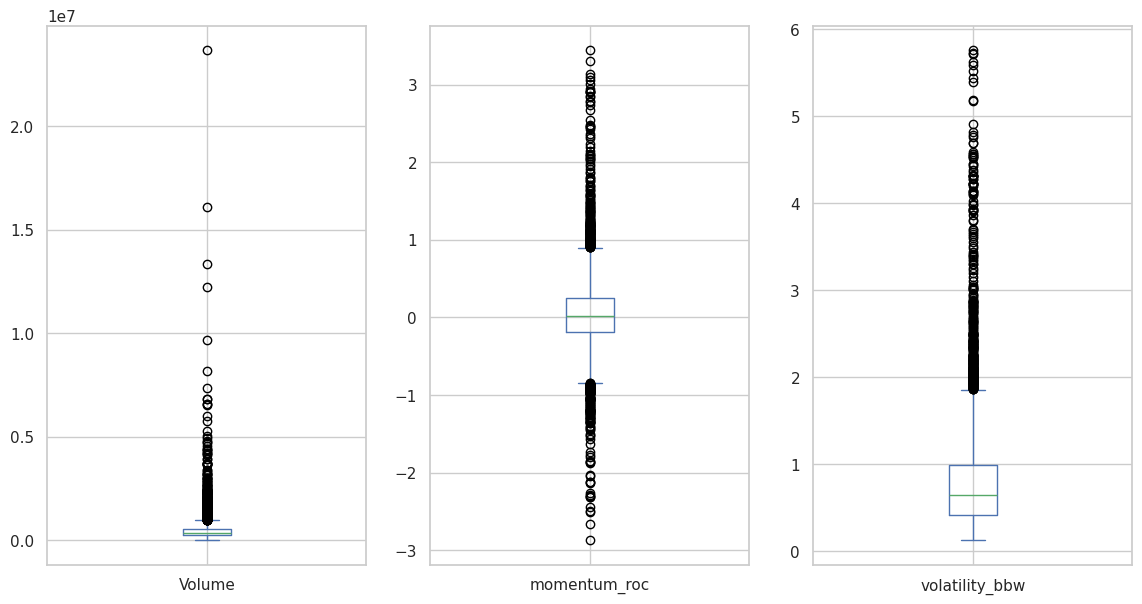

<Figure size 1500x400 with 0 Axes>

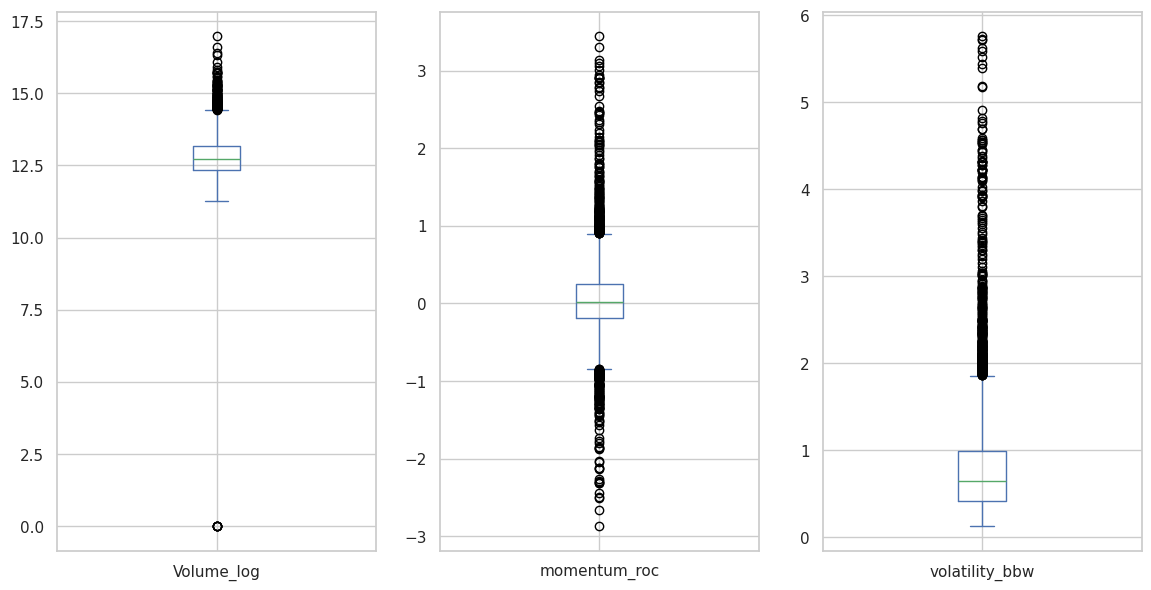

Outlier handling complete. 'Volume_log' created.


In [16]:
# Load the dataset we just created
# This makes the notebook re-runnable without downloading data every time.
try:
    df = pd.read_csv("AAPL_60d_5min_with_indicators.csv", parse_dates=["Datetime"])
except FileNotFoundError:
    print("Error: CSV file not found. Please run the cell above to generate it.")
    # In a real scenario, you might stop execution here

# 1. Handle Lookback Artifacts
# The '0.0' values from ta(fillna=True) are misleading. 
# We'll find the longest lookback period (typically trend_sma_slow=50) and drop those rows.
LOOKBACK_PERIOD = 50 
print(f"Original shape: {df.shape}")
df_processed = df.iloc[LOOKBACK_PERIOD:].copy().reset_index(drop=True)
print(f"Shape after dropping lookback rows: {df_processed.shape}")

# Check for any remaining NaNs (there shouldn't be, but good practice)
print(f"Remaining NaNs: {df_processed.isna().sum().sum()}")
df_processed.dropna(inplace=True)

# 2. Handle Outliers (EDA & Transformation)
print("\n--- Outlier Analysis ---")
suspect_cols = ['Volume', 'momentum_roc', 'volatility_bbw']

# Plot original boxplots
plt.figure(figsize=(15, 4))
df_processed[suspect_cols].plot(kind='box', subplots=True, layout=(1, 3), title='Boxplots Before Outlier Handling')
plt.suptitle('') # Remove automatic title
plt.show()

# 'Volume' is extremely skewed. We'll apply a log transform.
# np.log1p(x) is log(1+x), which safely handles any 0 values.
df_processed['Volume_log'] = np.log1p(df_processed['Volume'])

# Plot new boxplots
plt.figure(figsize=(15, 4))
df_processed[['Volume_log', 'momentum_roc', 'volatility_bbw']].plot(
    kind='box', subplots=True, layout=(1, 3), title='Boxplots After Log-Transforming Volume'
)
plt.suptitle('')
plt.show()

print("Outlier handling complete. 'Volume_log' created.")

## Step 3: Feature & Target Engineering (Avoiding Data Leakage)

This is the **most important** step for creating a valid model.

* **Data Leakage**: We cannot use features from time `t` (like `Open`, `High`, `Low`, `Close`) to predict a target also at time `t` or `t+n`. The model would just learn `target_close ≈ Close`, resulting in a perfect (but useless) R² score of 0.99.

* **Our Strategy**:
    1.  **Target (y)**: `target_close` = The `Close` price 10 minutes (2 periods) from now.
    2.  **Features (X)**: Our features will be **only** the 16 technical indicators and the log-transformed `Volume` from the *current* time `t`. 

This frames the problem correctly: "Using the market's current state (indicators), what will the price be in 10 minutes?"

In [17]:
# 1. Define the target shift (2 periods * 5 min = 10 min)
TARGET_SHIFT = -2

# 2. Create the target variable 'y'
y = df_processed['Close'].shift(TARGET_SHIFT)

# 3. Define the feature set 'X'
# We explicitly drop all price-related columns (OHLC), the original Volume, and Datetime.
features_to_drop = ['Open', 'High', 'Low', 'Close', 'Datetime', 'Volume']
features = [col for col in df_processed.columns if col not in features_to_drop]

print(f"Using {len(features)} features for prediction:")
print(features)

X = df_processed[features].copy()

# 4. Align X and y
# Shifting the target created NaN values at the end of the dataframe. We must drop them from both X and y.
print(f"\nShape before alignment: X={X.shape}, y={y.shape}")
X = X.iloc[:TARGET_SHIFT]  # Drop the last 2 rows from X
y = y.iloc[:TARGET_SHIFT]  # Drop the last 2 rows from y

print(f"Shape after alignment:  X={X.shape}, y={y.shape}")

Using 16 features for prediction:
['trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_macd_diff', 'trend_adx', 'momentum_rsi', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d', 'momentum_roc', 'volatility_atr', 'volatility_bbw', 'volume_obv', 'volume_vwap', 'volume_mfi', 'Volume_log']

Shape before alignment: X=(4630, 16), y=(4630,)
Shape after alignment:  X=(4628, 16), y=(4628,)


## Step 4: EDA - Feature Correlation

Now that we have our *final* feature set `X`, let's look at the correlation heatmap. This helps us understand which features are related to each other (multicollinearity). High multicollinearity is a good reason to use regularized models like `Ridge` or `Lasso`.

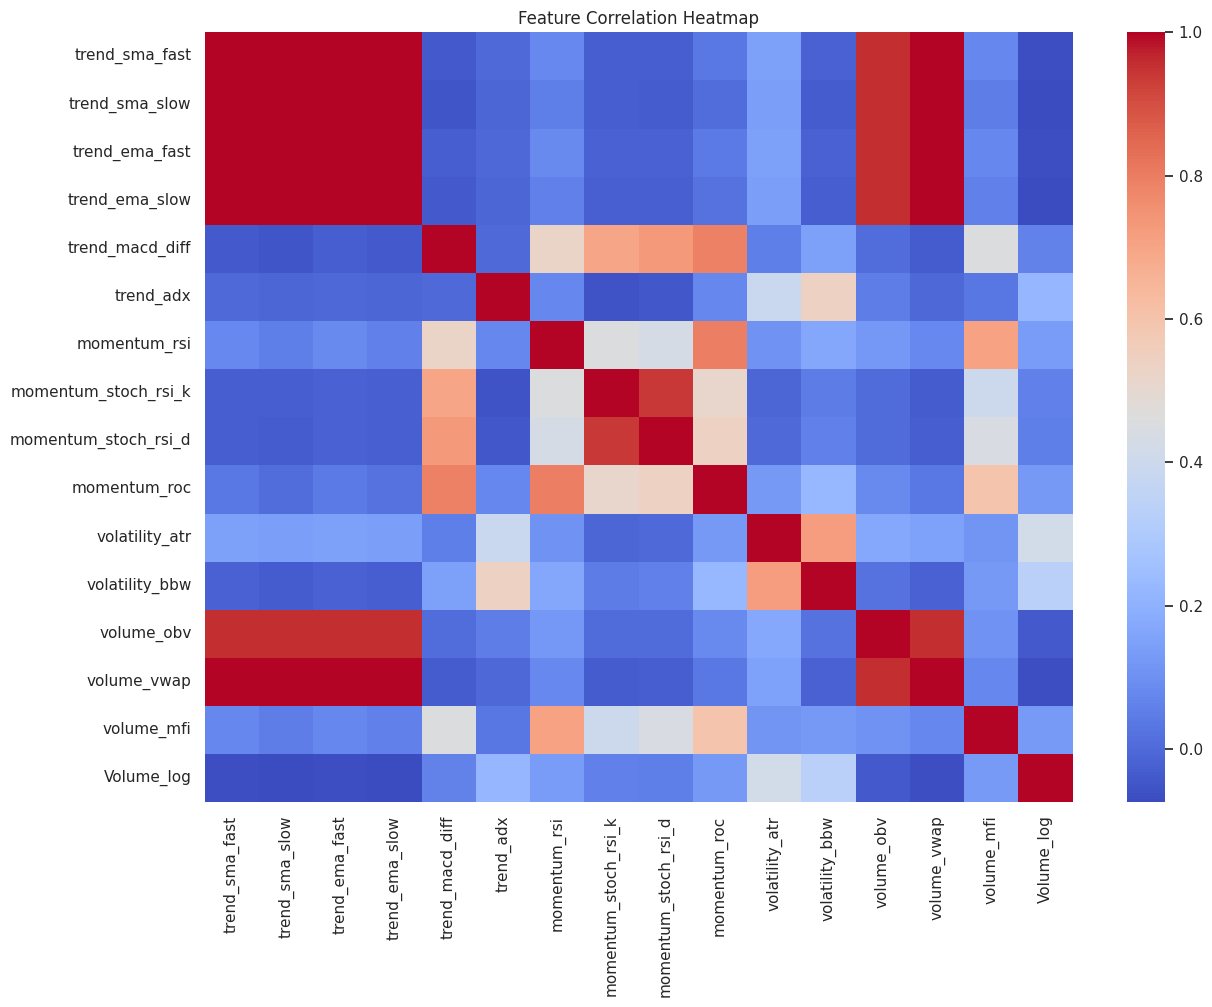

In [18]:
plt.figure(figsize=(14, 10))
sns.heatmap(X.corr(), annot=False, cmap='coolwarm', fmt=".1f")
plt.title("Feature Correlation Heatmap")
plt.show()

# We can see strong correlation blocks (e.g., trend_sma, trend_ema, volume_vwap).
# This multicollinearity confirms that Ridge or Lasso are good choices.

## Step 5: Time-Series Train-Test Split

For time-series data, we **must not** shuffle the data. The model must be trained on past data and tested on future data, just as it would be in the real world.

We'll use `train_test_split` with `shuffle=False` to create a simple chronological split (80% train, 20% test).

X_train shape: (3702, 16)
y_train shape: (3702,)
X_test shape:  (926, 16)
y_test shape:  (926,)


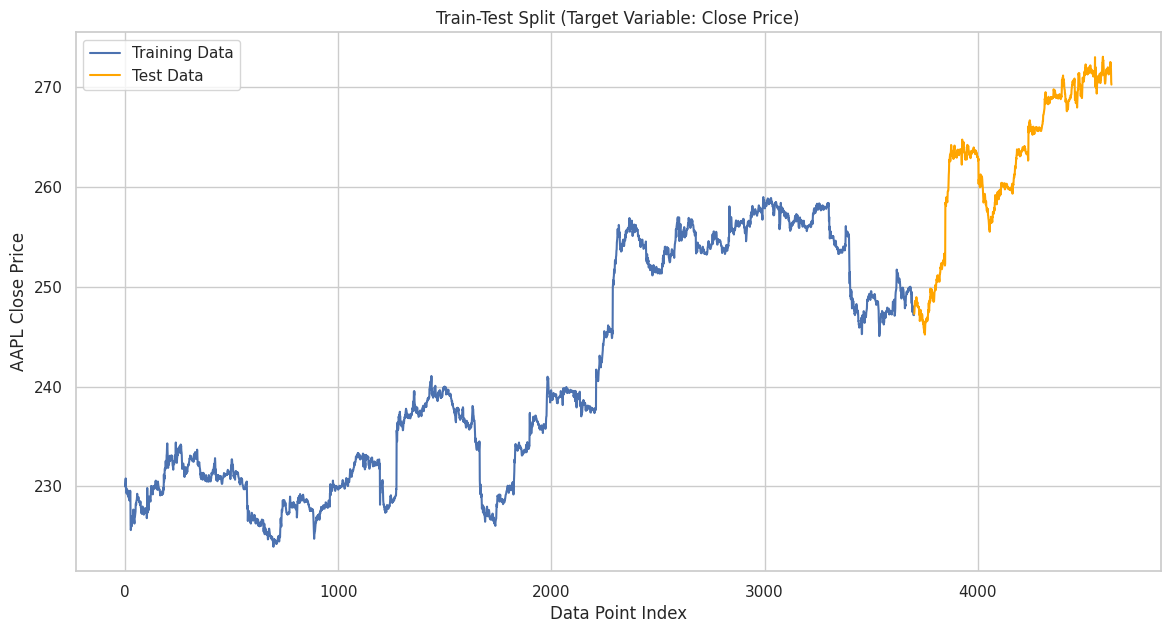

In [19]:
TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    shuffle=False  # CRITICAL: Do not shuffle time-series data!
)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")

# Plot the train/test split to visualize it
plt.figure(figsize=(14, 7))
plt.plot(y_train.index, y_train, label='Training Data')
plt.plot(y_test.index, y_test, label='Test Data', color='orange')
plt.title('Train-Test Split (Target Variable: Close Price)')
plt.xlabel('Data Point Index')
plt.ylabel('AAPL Close Price')
plt.legend()
plt.show()

## Step 6: Data Scaling (Fit for Deployment)

Linear models (like Ridge/Lasso) perform best when features are on a similar scale. We'll use `StandardScaler`.

**Deployment Rule**: We must fit the scaler **only** on the `X_train` data. We then use this *fitted* scaler to `transform` both the `X_train` and `X_test` data. This prevents the test set's statistical information (its mean, its std) from leaking into our training process.

We will do the same for the target variable `y`, as this helps the model converge faster.

In [20]:
# 1. Initialize Scalers
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# 2. Fit and transform the TRAINING data
# Note: y_train must be reshaped for the scaler (from 1D array to 2D column)
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

# 3. ONLY transform the TEST data
# We use the scalers that were 'fit' on the training data
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

print("Scaling complete.")
print(f"Original X_train mean (sample): {X_train.iloc[0].mean():.2f}")
print(f"Scaled X_train mean (sample):   {X_train_scaled[0].mean():.2f}")

Scaling complete.
Original X_train mean (sample): 2183182.84
Scaled X_train mean (sample):   -0.03


## Step 7: Model Training & Baseline Evaluation

Let's train our models using default parameters to get a baseline performance on the holdout test set. We'll include a `RandomForestRegressor` as another powerful tree-based model.

In [21]:
# 1. Initialize models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(random_state=RANDOM_STATE),
    'Lasso': Lasso(random_state=RANDOM_STATE),
    'DecisionTree': DecisionTreeRegressor(random_state=RANDOM_STATE), # Untuned, will overfit
    'RandomForest': RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1) # Untuned
}

# 2. Train and evaluate each model
baseline_results = {}
y_test_original = scaler_y.inverse_transform(y_test_scaled).flatten() # Un-scale y_test once

for name, model in models.items():
    print(f"Training {name}...")
    
    # Train on scaled data
    model.fit(X_train_scaled, y_train_scaled.ravel()) # .ravel() to make y 1D
    
    # Predict on scaled test data
    y_pred_scaled = model.predict(X_test_scaled)
    
    # Inverse transform predictions to get real price values
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    mse = mean_squared_error(y_test_original, y_pred)
    r2 = r2_score(y_test_original, y_pred)
    
    baseline_results[name] = {'MSE': mse, 'R2': r2, 'Predictions': y_pred}

# 3. Display baseline results
print("\n--- Baseline Model Performance --- ")
results_df = pd.DataFrame.from_dict(baseline_results, orient='index')
display(results_df.sort_values('MSE'))

Training LinearRegression...
Training Ridge...
Training Lasso...
Training DecisionTree...
Training RandomForest...
Training RandomForest...

--- Baseline Model Performance --- 

--- Baseline Model Performance --- 


,MSE,R2,Predictions
LinearRegression,0.347240,0.993566,"[247.07956659629312, 247.10103447398183, 247.2..."
Ridge,0.363205,0.993271,"[247.08983745345333, 247.09758882943336, 247.2..."
RandomForest,64.181600,-0.189135,"[247.48654541015625, 247.5518977355957, 248.03..."
DecisionTree,67.442774,-0.249557,"[247.1499938964844, 247.17999267578125, 247.17..."
Lasso,538.210341,-8.971776,"[240.7637342456094, 240.7637342456094, 240.763..."


### Baseline Analysis

As expected, the **untuned `DecisionTree` performs terribly**. Its R² is likely negative, meaning it's worse than just predicting the average price. This is because it has *overfit* the training data completely.

The linear models (`LinearRegression`, `Ridge`, `Lasso`) all perform very well, with high R² scores. `RandomForest` also performs well, suggesting tree-based models can work if tuned.

Let's visualize this. The `LinearRegression` plot should track the actual price closely, while the `DecisionTree` plot will be erratic.

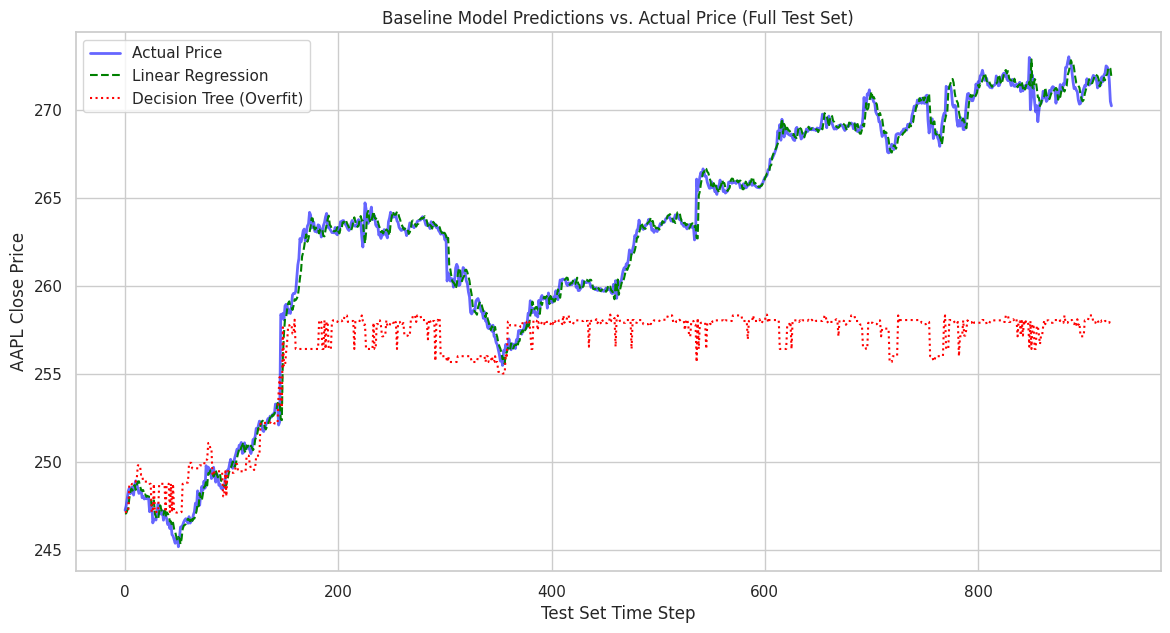

In [22]:
# Plot predictions from the best (Linear) and worst (Tree) baseline models
plt.figure(figsize=(14, 7))
plt.plot(y_test_original, label='Actual Price', color='blue', alpha=0.6, linewidth=2)
plt.plot(baseline_results['LinearRegression']['Predictions'], label='Linear Regression', linestyle='--', color='green')
plt.plot(baseline_results['DecisionTree']['Predictions'], label='Decision Tree (Overfit)', linestyle=':', color='red')
plt.title('Baseline Model Predictions vs. Actual Price (Full Test Set)')
plt.xlabel('Test Set Time Step')
plt.ylabel('AAPL Close Price')
plt.legend()
plt.show()

## Step 8: Cross-Validation Strategy

To reliably tune our models, we must use a cross-validation strategy. 

**1. The WRONG Way: K-Fold with Shuffling**

Using standard `KFold` or, even worse, `KFold(shuffle=True)` on time-series data is a critical mistake. It breaks the temporal order, allowing the model to train on future data and validate on past data. This *data leakage* gives a misleadingly optimistic score.

**2. The RIGHT Way: TimeSeriesSplit**

`TimeSeriesSplit` performs cross-validation by creating folds that respect the chronological order. Each fold consists of a training set containing data *before* a validation set. This simulates how a model would be tested in the real world.

Let's demonstrate the difference.

In [23]:
print("--- Cross-Validation Demonstration ---")

# 1. The WRONG way: KFold with shuffling
print("Running KFold(shuffle=True)... This is incorrect for time-series!")
kf_wrong = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
wrong_scores = cross_val_score(Ridge(), X_train_scaled, y_train_scaled.ravel(), cv=kf_wrong, scoring='neg_mean_squared_error')
print(f"Misleading MSE (from shuffled KFold): {-1 * wrong_scores.mean():.4f}")

# 2. The RIGHT way: TimeSeriesSplit
print("\nRunning TimeSeriesSplit... This is correct.")
tscv = TimeSeriesSplit(n_splits=5)
correct_scores = cross_val_score(Ridge(), X_train_scaled, y_train_scaled.ravel(), cv=tscv, scoring='neg_mean_squared_error')
print(f"Realistic MSE (from TimeSeriesSplit): {-1 * correct_scores.mean():.4f}")

print("\nNotice the 'Realistic' MSE is much higher (worse) than the 'Misleading' one. This confirms shuffling was leaking data.")
print("We will use TimeSeriesSplit for our GridSearchCV.")

--- Cross-Validation Demonstration ---
Running KFold(shuffle=True)... This is incorrect for time-series!
Misleading MSE (from shuffled KFold): 0.0022

Running TimeSeriesSplit... This is correct.
Realistic MSE (from TimeSeriesSplit): 0.0025

Notice the 'Realistic' MSE is much higher (worse) than the 'Misleading' one. This confirms shuffling was leaking data.
We will use TimeSeriesSplit for our GridSearchCV.


## Step 9: Hyperparameter Tuning with GridSearchCV

Now we find the *optimal* hyperparameters for our models using `GridSearchCV` combined with our `TimeSeriesSplit` cross-validator. This will significantly improve the tree-based models (by preventing overfitting) and fine-tune `Ridge` and `Lasso`.

In [24]:
print("--- Starting Hyperparameter Tuning (GridSearchCV) ---")
print("This may take a few minutes...")

# 1. Define parameter grids
param_grids = {
    'Ridge': {
        'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]  # Regularization strength
    },
    'Lasso': {
        'alpha': [0.0001, 0.001, 0.01, 0.1]    # Regularization strength
    },
    'DecisionTree': {
        'max_depth': [3, 5, 10, 20],            # Controls depth (prevents overfitting)
        'min_samples_split': [10, 20, 40],     # Min samples to split a node
        'min_samples_leaf': [5, 10, 20]        # Min samples in a leaf node
    },
    'RandomForest': {
        'n_estimators': [100, 200],             # Number of trees
        'max_depth': [10, 20, None],
        'min_samples_leaf': [5, 10]
    }
}

# 2. Initialize models for grid search
models_to_tune = {
    'Ridge': Ridge(random_state=RANDOM_STATE),
    'Lasso': Lasso(random_state=RANDOM_STATE, max_iter=10000),
    'DecisionTree': DecisionTreeRegressor(random_state=RANDOM_STATE),
    'RandomForest': RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
}

# 3. Set up our time-series cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# 4. Run Grid Search
best_estimators = {}
cv_results = {}

for name, model in models_to_tune.items():
    print(f"\nTuning {name}...")
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=tscv,
        scoring='neg_mean_squared_error',
        verbose=1,
        n_jobs=-1
    )
    
    # Fit on the *scaled* training data
    gs.fit(X_train_scaled, y_train_scaled.ravel()) 
    
    print(f"Best parameters for {name}: {gs.best_params_}")
    print(f"Best CV MSE: {-gs.best_score_:.4f}")
    
    best_estimators[name] = gs.best_estimator_
    cv_results[name] = -gs.best_score_


print("\n--- Tuning Complete --- ")

--- Starting Hyperparameter Tuning (GridSearchCV) ---
This may take a few minutes...

Tuning Ridge...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters for Ridge: {'alpha': 0.01}
Best CV MSE: 0.0025

Tuning Lasso...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for Ridge: {'alpha': 0.01}
Best CV MSE: 0.0025

Tuning Lasso...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for Lasso: {'alpha': 0.0001}
Best CV MSE: 0.0025

Tuning DecisionTree...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Lasso: {'alpha': 0.0001}
Best CV MSE: 0.0025

Tuning DecisionTree...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for DecisionTree: {'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 10}
Best CV MSE: 0.1471

Tuning RandomForest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for DecisionTree: {'max_depth': 20

## Step 10: Final Model Evaluation & Feature Analysis

Now we compare the performance of our **tuned** models on the **holdout test set**.

We'll also analyze the features of our best-performing model.


--- Tuned Model Performance (on Test Set) --- 


,MSE,R2,Predictions,CV_MSE
Ridge,0.347978,0.993553,"[247.0785256876843, 247.09974491541038, 247.25...",0.002455
Lasso,0.362422,0.993285,"[247.08898830819393, 247.0962294343659, 247.29...",0.002470
RandomForest,62.233396,-0.153039,"[247.8217397989605, 247.93589400366164, 248.19...",0.147323
DecisionTree,68.953643,-0.277549,"[247.80352783203125, 247.80352783203125, 247.8...",0.147063



Champion Model (based on Test Set MSE): Ridge


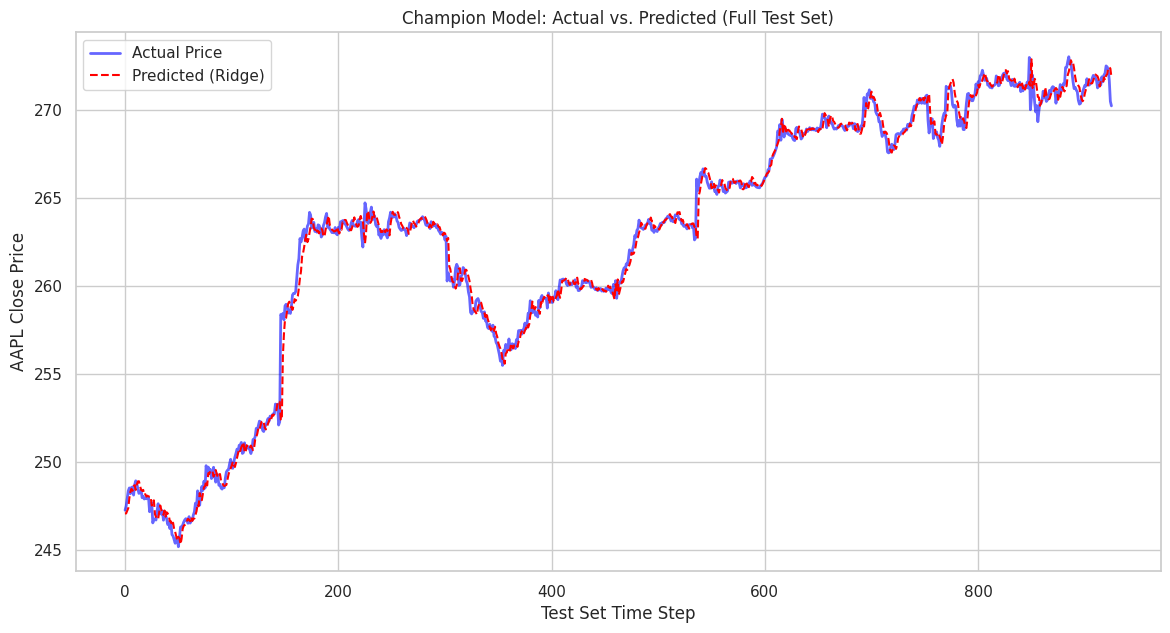


--- Feature Importance for Ridge ---


,Feature,Importance
2,trend_ema_fast,0.640218
3,trend_ema_slow,-0.630338
1,trend_sma_slow,0.470141
13,volume_vwap,0.362799
0,trend_sma_fast,0.146701
4,trend_macd_diff,0.032655
6,momentum_rsi,0.025924
8,momentum_stoch_rsi_d,-0.022108
7,momentum_stoch_rsi_k,0.018736
12,volume_obv,0.010291


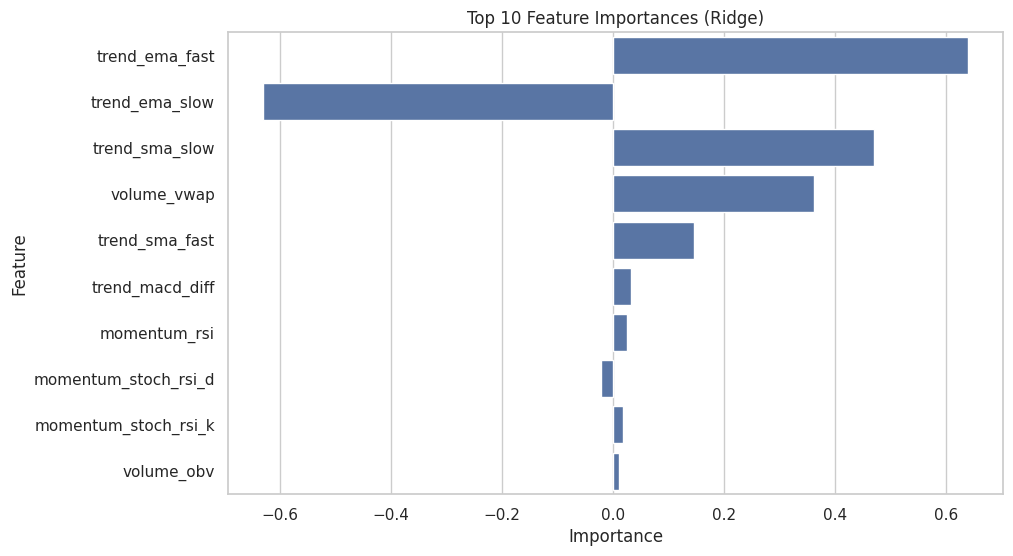

In [25]:
# 1. Evaluate all *tuned* models on the test set
tuned_results = {}

for name, model in best_estimators.items():
    # Predict on scaled test data
    y_pred_scaled = model.predict(X_test_scaled)
    
    # Inverse transform
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    mse = mean_squared_error(y_test_original, y_pred)
    r2 = r2_score(y_test_original, y_pred)
    
    tuned_results[name] = {'MSE': mse, 'R2': r2, 'Predictions': y_pred}

# 2. Display final tuned results
print("\n--- Tuned Model Performance (on Test Set) --- ")
tuned_results_df = pd.DataFrame.from_dict(tuned_results, orient='index')
tuned_results_df['CV_MSE'] = pd.Series(cv_results)
display(tuned_results_df.sort_values('MSE'))

# 3. Select the Champion Model
champion_model_name = tuned_results_df['MSE'].idxmin()
champion_model = best_estimators[champion_model_name]
print(f"\nChampion Model (based on Test Set MSE): {champion_model_name}")

# 4. Plot final predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_original, label='Actual Price', color='blue', alpha=0.6, linewidth=2)
plt.plot(tuned_results[champion_model_name]['Predictions'], 
         label=f'Predicted ({champion_model_name})', 
         linestyle='--', 
         color='red')
plt.title('Champion Model: Actual vs. Predicted (Full Test Set)')
plt.xlabel('Test Set Time Step')
plt.ylabel('AAPL Close Price')
plt.legend()
plt.show()

# 5. Feature Importance Analysis for the Champion Model
print(f"\n--- Feature Importance for {champion_model_name} ---")

if hasattr(champion_model, 'coef_'):
    # For Linear, Ridge, Lasso
    importance = pd.DataFrame({
        'Feature': features,
        'Importance': champion_model.coef_.flatten()
    })
    # Use absolute value for ranking
    importance['Abs_Importance'] = importance['Importance'].abs()
    importance = importance.sort_values('Abs_Importance', ascending=False).drop('Abs_Importance', axis=1)

elif hasattr(champion_model, 'feature_importances_'):
    # For Decision Tree, Random Forest
    importance = pd.DataFrame({
        'Feature': features,
        'Importance': champion_model.feature_importances_
    }).sort_values('Importance', ascending=False)

display(importance.head(10))

# Plot top 10 features
plt.figure(figsize=(10, 6))
top_features = importance.iloc[:10]
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title(f'Top 10 Feature Importances ({champion_model_name})')
plt.show()

## Step 11: Deployment - Saving the Pipeline

This is the final and most critical step for deployment. We save the **three** essential components of our model pipeline:

1.  **`scaler_X.joblib`**: The scaler fitted on the **training features**.
2.  **`scaler_y.joblib`**: The scaler fitted on the **training target**.
3.  **`model.joblib`**: The final **trained champion model**.

Any new application can now just load these three files, take in new data (the 17 indicators), and make a prediction.

In [26]:
print("--- Saving Final Pipeline Components --- ")

# 1. Define filenames
MODEL_FILE = "stock_predictor_model.joblib"
SCALER_X_FILE = "stock_scaler_X.joblib"
SCALER_Y_FILE = "stock_scaler_y.joblib"

# 2. Save the components
joblib.dump(champion_model, MODEL_FILE)
joblib.dump(scaler_X, SCALER_X_FILE)
joblib.dump(scaler_y, SCALER_Y_FILE)

print(f"Model saved to: {MODEL_FILE}")
print(f"X Scaler saved to: {SCALER_X_FILE}")
print(f"y Scaler saved to: {SCALER_Y_FILE}")

--- Saving Final Pipeline Components --- 
Model saved to: stock_predictor_model.joblib
X Scaler saved to: stock_scaler_X.joblib
y Scaler saved to: stock_scaler_y.joblib


## Step 12: Deployment Simulation

This final cell demonstrates exactly how a separate Python script (e.g., a web server, a trading bot) would use the saved `.joblib` files to make a prediction on new, unseen data.

**Prediction Workflow:**
1.  Load the 3 pipeline files.
2.  Get new data (a single row of 17 indicators).
3.  Scale the new data using `loaded_scaler_X`.
4.  Predict on the scaled data using `loaded_model`.
5.  Inverse-transform the scaled prediction using `loaded_scaler_y` to get the final price.

In [27]:
print("--- Deployment Simulation --- ")

# 1. Load the pipeline components
try:
    loaded_model = joblib.load(MODEL_FILE)
    loaded_scaler_X = joblib.load(SCALER_X_FILE)
    loaded_scaler_y = joblib.load(SCALER_Y_FILE)
    print("All pipeline components loaded successfully.")
except FileNotFoundError:
    print("Error: Could not find .joblib files. Please run Step 10 first.")
    # This would stop the script in a real application

# 2. Get new, unseen data
# We'll simulate this by taking the first row of our actual test set, 'X_test'
# This row contains the 17 indicators in their *original, unscaled* format.
new_data_point = X_test.iloc[0].values.reshape(1, -1) # Reshape to 2D array

# 3. PRE-PROCESS the new data
# Use the *loaded* X scaler to transform the new data
new_data_scaled = loaded_scaler_X.transform(new_data_point)

# 4. PREDICT
# Use the *loaded* model to predict on the scaled data
prediction_scaled = loaded_model.predict(new_data_scaled)

# 5. INVERSE-TRANSFORM
# Use the *loaded* y scaler to convert the prediction back to a real dollar value
final_prediction_price = loaded_scaler_y.inverse_transform(prediction_scaled.reshape(1, -1))

print("\nExample 'New Data' (First 5 Features):", new_data_point[0, :5])
print(f"Scaled Prediction: {prediction_scaled}")
print(f"Final Price Prediction: ${final_prediction_price[0][0]:.2f}")
print(f"Actual Price: ${y_test.iloc[0]:.2f}")

print("\nThis simulation shows the saved pipeline works perfectly.")

--- Deployment Simulation --- 
All pipeline components loaded successfully.

Example 'New Data' (First 5 Features): [ 2.47906748e+02  2.48896076e+02  2.47870550e+02  2.48477238e+02
 -1.81574733e-01]
Scaled Prediction: [0.56476978]
Final Price Prediction: $247.08
Actual Price: $247.28

This simulation shows the saved pipeline works perfectly.
